# PPO (Proximal Policy Optimization)

Proximal Policy Optimization (PPO) is one of most successful algorithms in today's reinforcement learning.

In order to avoid the loss of performance, PPO algorithm prevents the update from stepping so far.<br>
In PPO, there are two variants: PPO-Penalty and PPO-Clip. In this example, we'll focus on PPO-Penalty, which is used in RLlib library.

> Note : The idea of PPO-Clip is more simple rather than PPO-Penalty. PPO-Clip limits the update by directly clipping with $ \epsilon $.<br>
> For details about PPO-Clip, see [OpenAI document](https://spinningup.openai.com/en/latest/algorithms/ppo.html).

As you saw in [Actor-Critic method](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/03-actor-critic.ipynb), the algorithm will learn policy parameters ($ \theta $) with advantages $ A $.<br>
When we assume that the agent takes large advantage $ A $ on action $ a $, $ P(a | \pi_\theta (s)) $ must be increased much more than $ P(a | \pi_{\theta_{old}} (s)) $, with new parameters $ \theta $. Hence you can expect new $ \theta $ as follows. :

$$ \max_{\theta} E \left[ \frac{P(a | \pi_\theta (s))}{P(a | \pi_{\theta_{old}} (s))} A \right] $$

In order to prevent large policy updates, PPO penaltize for this expectation as follows :

$$ \max_{\theta} E \left[ \frac{P(a | \pi_\theta (s))}{P(a | \pi_{\theta_{old}} (s))} A - \beta \cdot \verb|penalty| \right] $$

where $ \beta $ is the coefficient for the weight of penalty.

In PPO-Penalty, KL-divergence is used as this penalty. :

$$ \verb|penalty| = \verb|KL| \left( P(\cdot | \pi_{\theta_{old}} (s)) \| P(\cdot | \pi_\theta (s)) \right) $$

KL-divergence or Kullback-Leibler divergence is often used in information theory, such as, approximate inference.<br>
Now we assume that both $ P(x) $ and $ Q(x) $ are stochastic distributions. Then $ \verb|KL|( P \| Q ) := -\int{P(x) \ln{\frac{Q(x)}{P(X)}}}dx $ is always positive or zero, and zero if and only if both distributions are same.<br>
$ \verb|KL|( P \| Q ) $ indicates how far between these distributions, $ P $ and $ Q $. If $ Q $ is so far from $ P $, $ \verb|KL|( P \| Q ) $ will be largely positive.

> Note : For details about entropy and KL-divergence, see chapter 1.6 in "[Pattern Recognition and Machine Learning](http://wordpress.redirectingat.com/?id=725X1342&isjs=1&jv=15.1.0-stackpath&sref=https%3A%2F%2Ftsmatz.wordpress.com%2F2020%2F06%2F01%2Fsvm-and-kernel-functions-mathematics%2F&url=https%3A%2F%2Fwww.microsoft.com%2Fen-us%2Fresearch%2Fuploads%2Fprod%2F2006%2F01%2FBishop-Pattern-Recognition-and-Machine-Learning-2006.pdf&xguid=&xs=1&xtz=-540&xuuid=c861da822b99f831a421716ca3a51d33&xcust=8982&xjsf=other_click__auxclick%20%5B2%5D)" (Christopher M. Bishop, Microsoft).

In order to penaltize for large update between $ P(\cdot | \pi_{\theta_{old}} (s)) $ and $ P(\cdot | \pi_\theta (s)) $, we look for the optimal parameters $ \theta $, such as :

$$ \max_{\theta} E \left[ \frac{P(a | \pi_\theta (s))}{P(a | \pi_{\theta_{old}} (s))} A - \beta \cdot \verb|KL| \left( P(\cdot | \pi_{\theta_{old}} (s)) \| P(\cdot | \pi_\theta (s)) \right) \right] $$

Even if $ \frac{P(a | \pi_\theta (s))}{P(a | \pi_{\theta_{old}} (s))} A $ largely increases, new $ \theta $ might be rejected when the difference between $ P(\cdot | \pi_{\theta_{old}} (s)) $ and $ P(\cdot | \pi_\theta (s)) $ is so large.

See [this paper](https://arxiv.org/pdf/1707.06347.pdf) for more details about PPO.

> Note : In this example, we ignore (don't consider) an entropy regularizer.

*(back to [index](https://github.com/tsmatz/reinforcement-learning-tutorials/))*

First, please install the required packages and import these modules.

In [ ]:
!pip install numpy gym keras tensorflow==2.4 matplotlib

In [1]:
import gym
import numpy as np
import tensorflow as tf

As you saw in [Actor-Critic](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/03-actor-critic.ipynb), now we build policy network $ \pi(\cdot) $ for the outputs of both action distribution (logits for categorical action) and value estimation. (i.e, this is a network for both policy function and value function.)

In [2]:
s_input = tf.keras.layers.Input(shape=(4, ))

a_hidden = tf.keras.layers.Dense(16,activation="relu")(s_input)
a_output = tf.keras.layers.Dense(2,activation="relu")(a_hidden)

v_hidden = tf.keras.layers.Dense(16,activation="relu")(s_input)
v_output = tf.keras.layers.Dense(1,activation=None)(v_hidden)

policy_pi = tf.keras.Model([s_input], [a_output, v_output])

Now we optimize both expectation (see above) and loss.

Instead of maximizing $ \frac{P(a | \theta_{new})}{P(a | \theta_{old})} A - \beta \cdot \verb|KL| \left( P(\theta_{old}) \| P(\theta_{new}) \right) $ and minimizing loss, here we minimize the following tensor :

$$ (-1) \frac{P(a | \theta_{new})}{P(a | \theta_{old})} A + \beta \cdot \verb|KL| \left( P(\theta_{old}) \| P(\theta_{new}) \right) + loss $$

Unlike [Actor-Critic sample](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/03-actor-critic.ipynb), here I train the parameters with batch in each episode.

> Note : The log probability equals to the negative value of cross-entropy error. Same like [policy gradient example](https://github.com/tsmatz/reinforcement-learning-tutorials/blob/master/02-policy-gradient.ipynb), I used ```-tf.nn.sparse_softmax_cross_entropy_with_logits()``` to get log probability in the following code.

In [3]:
gamma = 0.99    # discount
kl_coeff = 0.2  # weight coefficient for KL-divergence loss
vl_coeff = 1.0  # weight coefficient for value loss

# pick up action and following properties for state (s)
# Return :
#     action (int)       action
#     logits (list[int]) logits defining categorical distribution
#     logprb (float)     log probability
def pick_sample_and_logp(s):
    logits_t, _ = policy_pi(tf.convert_to_tensor(np.array([s])))
    # return tf.Tensor([[a]], shape=(1, 1), dtype=int64)
    action_t = tf.random.categorical(logits_t, 1)
    # return tf.Tensor([a], shape=(1, 1), dtype=int64)
    action_t = tf.squeeze(action_t, axis=1)
    # calculate log probability
    logprb_t = -tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_t,
        labels=action_t)
    # get numpy action
    action = int(action_t.numpy()[0])
    # get numpy logits
    logits = logits_t.numpy()[0]
    # get numpy logprb
    logprb = logprb_t.numpy()[0]
    return action, logits, logprb

env = gym.make("CartPole-v0")
reward_records = []
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
for i in range(3000):
    # Run episode till done
    done = False
    states_arr = []
    action_arr = []
    logits_arr = []
    logprb_arr = []
    reward_arr = []
    s = env.reset()
    while not done:
        states_arr.append(s)
        a, p, l = pick_sample_and_logp(s)
        s_next, r, done, _ = env.step(a)
        action_arr.append([a])
        logits_arr.append(p)
        logprb_arr.append([l])
        reward_arr.append([r])
        s = s_next

    # Change to cumulative rewards
    rewcum_arr = np.zeros_like(reward_arr)
    reward_len = len(reward_arr)
    for j in reversed(range(reward_len)):
        cum_reward = reward_arr[j][0] + (rewcum_arr[j+1][0]*gamma if j+1 < reward_len else 0)
        rewcum_arr[j] = [cum_reward]

    # Output total rewards in episode (max 200)
    print("Run episode{} with rewards {}".format(i, np.sum(reward_arr)), end="\r")
    reward_records.append(np.sum(reward_arr))

    # Train parameters
    with tf.GradientTape() as tape:
        states_arr_t = tf.convert_to_tensor(states_arr)
        action_arr_t = tf.convert_to_tensor(action_arr)
        logits_arr_t = tf.convert_to_tensor(logits_arr)
        logprb_arr_t = tf.convert_to_tensor(logprb_arr)
        rewcum_arr_t = tf.convert_to_tensor(rewcum_arr, dtype=tf.float32)
        logits_new_t, value_new_t = policy_pi(states_arr_t, training=True)

        # Get advantage
        advantage_t = rewcum_arr_t - value_new_t

        # Calculate P_new / P_old
        logprb_new_t = -tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits_new_t,
            labels=tf.squeeze(action_arr_t, axis=1))
        logprb_new_t = tf.expand_dims(logprb_new_t, 1)
        prob_ratio = tf.exp(logprb_new_t - logprb_arr_t)

        # Calculate KL-div for Categorical distribution
        a0 = logits_arr_t - tf.reduce_max(logits_arr_t, axis=1, keepdims=True)
        a1 = logits_new_t - tf.reduce_max(logits_new_t, axis=1, keepdims=True)
        ea0 = tf.exp(a0)
        ea1 = tf.exp(a1)
        z0 = tf.reduce_sum(ea0, axis=1, keepdims=True)
        z1 = tf.reduce_sum(ea1, axis=1, keepdims=True)
        p0 = ea0 / z0
        kl = tf.reduce_sum(
            p0 * (a0 - tf.math.log(z0) - a1 + tf.math.log(z1)), axis=1)
        kl = tf.expand_dims(kl, 1)

        # Get value loss
        v_loss = tf.math.square(value_new_t - rewcum_arr_t)

        # Minimize loss
        grad = tape.gradient(
            -advantage_t * prob_ratio + kl_coeff * kl + vl_coeff * v_loss,
            policy_pi.trainable_variables)
        opt.apply_gradients(zip(grad, policy_pi.trainable_variables))

print("\nDone")
env.close()

Run episode2999 with rewards 200.0
Done


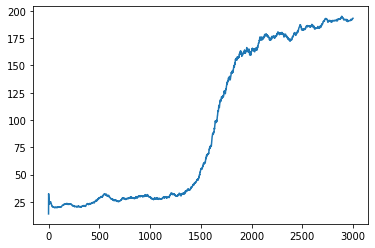

In [4]:
import matplotlib.pyplot as plt
# Generate recent 100 interval average
reward_records_np = np.array(reward_records)
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 100:
        avg_list = reward_records_np[:idx+1]
    else:
        avg_list = reward_records_np[idx-99:idx+1]
    average_reward.append(np.average(avg_list))
plt.plot(average_reward)